In [1]:
from dotenv import load_dotenv 

load_dotenv()

True

In [2]:
from langchain_openai import ChatOpenAI 

llm = ChatOpenAI(model='gpt-4o')
small_llm = ChatOpenAI(model='gpt-4o-mini')

In [3]:
from langchain_core.tools import tool

@tool
def add(a: int, b: int) -> int:
    """숫자 a와 b를 더합니다."""
    return a + b

@tool
def multiply(a: int, b: int) -> int:
    """숫자 a와 b를 곱합니다."""
    return a * b

In [4]:
from langchain_community.tools import DuckDuckGoSearchRun

search_tool = DuckDuckGoSearchRun()

In [5]:
from langchain_google_community import GmailToolkit

from langchain_google_community.gmail.utils import (
    build_resource_service,
    get_gmail_credentials,
)

# Can review scopes here https://developers.google.com/gmail/api/auth/scopes
# For instance, readonly scope is 'https://www.googleapis.com/auth/gmail.readonly'
credentials = get_gmail_credentials(
    token_file="./google/gmail_token.json",
    scopes=["https://mail.google.com/"],
    client_secrets_file="./google/gmail_credentials.json",
)
api_resource = build_resource_service(credentials=credentials)
gmail_toolkit = GmailToolkit(api_resource=api_resource)
gmail_tool_list = gmail_toolkit.get_tools()


In [6]:
from langchain.agents import load_tools

loaded_tool_list = load_tools(
    ["arxiv"],
)

In [7]:
from langchain_chroma import Chroma 
from langchain_openai import OpenAIEmbeddings  
from langchain_core.tools.retriever import create_retriever_tool

embeddings = OpenAIEmbeddings(model='text-embedding-3-large')
vector_store = Chroma(
    embedding_function=embeddings,
    collection_name = 'real_estate_tax',
    persist_directory='./real_estate_tax_collection'
)

retriever = vector_store.as_retriever(search_kwargs={"k": 3})

retriever_tool = create_retriever_tool(
    retriever=retriever,
    name='real_estate_tax_retriever',
    description='Contains information about real estate tax up to December 2024',
)


In [8]:
from langgraph.prebuilt import ToolNode

tool_list = [add, multiply, search_tool, retriever_tool] + gmail_tool_list + loaded_tool_list
llm_with_tools = small_llm.bind_tools(tool_list)
tool_node = ToolNode(tool_list)

In [9]:
from langgraph.graph import MessagesState, StateGraph

class AgentState(MessagesState):
    summary: str

graph_builder = StateGraph(AgentState)

In [10]:
from langchain_core.messages import SystemMessage

def agent(state: AgentState) -> AgentState:
    # 메시지와 요약을 state에서 가져옵니다.
    messages = state['messages']
    summary = state['summary']
    
    # 요약이 비어있지 않으면, 요약을 메시지 앞에 추가합니다.
    if summary != '':
        messages = [SystemMessage(content=f'Here is the summary of the earlier conversation: {summary}')] + messages
    
    # LLM과 도구를 사용하여 메시지에 대한 응답을 생성합니다.
    response = llm_with_tools.invoke(messages)
    
    # 응답 메시지를 포함하는 새로운 state를 반환합니다.
    return {'messages': [response]}

In [11]:
def summarize_messages(state: AgentState) -> AgentState: 
    messages = state['messages']
    summary = state['summary']

    summary_prompt = f'summarize this chat history below:\n\nchat history:{messages}'

    if summary != '':
        summary_prompt = f'''summarize this chat history below while looking at the summary of earlier conversations
chat_history:{messages}
summary:{summary}'''
        
    summary = small_llm.invoke(summary_prompt)

    return {'summary': summary.content}

In [12]:
from langchain_core.messages import RemoveMessage

def delete_messages(state: AgentState) -> AgentState:
    """
    주어진 state에서 오래된 메시지를 삭제합니다.

    Args:
        state (AgentState): 메시지를 포함하는 state.

    Returns:
        AgentState: 삭제된 메시지를 포함하는 새로운 state.
    """
    # state에서 메시지를 가져옵니다.
    messages = state['messages']
    # 마지막 세 개의 메시지를 제외한 나머지 메시지를 삭제합니다.
    delete_messages = [RemoveMessage(id=message.id) for message in messages[:-3]]
    # 삭제된 메시지를 포함하는 새로운 state를 반환합니다.
    return {'messages': delete_messages}

In [13]:
from typing import Literal 

def should_continue(state: AgentState) -> Literal['tools', 'summarize_messgaes']:
    messages = state['messages']
    last_ai_message = messages[-1]

    if last_ai_message.tool_calls:
        return 'tools'
    
    return 'summarize_messages'

In [14]:
graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)
graph_builder.add_node(delete_messages)
graph_builder.add_node(summarize_messages)

In [15]:
from langgraph.graph import START, END 

graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
    'agent',
    should_continue,
    ['tools', 'summarize_messages']
)

graph_builder.add_edge('tools', 'agent')
graph_builder.add_edge('summarize_messages', 'delete_messages')
graph_builder.add_edge('delete_messages', END)

In [16]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()

graph= graph_builder.compile(checkpointer=checkpointer)

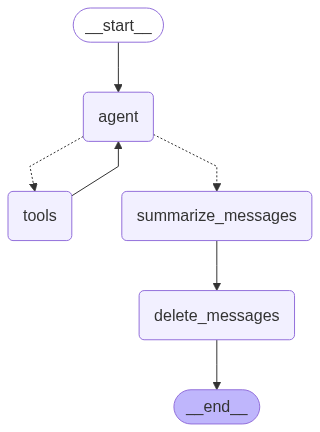

In [17]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
from langchain_core.messages import HumanMessage

config = {
    'configurable': {
        'thread_id': 'summarize_paper'
    }
}

query = 'robert@hanpoom.com으로 Attention Is All You Need 논문을 요약해서 이메일 초안을 작성해주세요'
for chunk in graph.stream({'messages': [HumanMessage(query)], 'summary': ''}, config=config, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

robert@hanpoom.com으로 Attention Is All You Need 논문을 요약해서 이메일 초안을 작성해주세요
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_gIgm366s5qp7wVQGPIYBPq0y)
 Call ID: call_gIgm366s5qp7wVQGPIYBPq0y
  Args:
    query: Attention Is All You Need
================================= Tool Message =================================
Name: arxiv

Published: 2024-07-22
Title: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models
Authors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini
Summary: The inference demand for LLMs has skyrocketed in recent months, and serving
models with low latencies remains challenging due to the quadratic input length
complexity of the attention layers. In this work, we investigate the effect of
dropping MLP and attention layers at inference time on the performance of
Llama-v2 model

In [19]:
current_message_list = graph.get_state(config).values['messages']
current_message_list

[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_LOSMdf5W8qEyKYktegvaAhn1', 'function': {'arguments': '{"message":"안녕하세요,\\n\\n\\"Attention Is All You Need\\" 논문에 대한 요약을 공유하고자 합니다.\\n\\n이 논문은 대규모 언어 모델(LLM)의 추론 수요가 최근 몇 달간 급증하고 있으며, 낮은 대기 시간으로 모델을 제공하는 것이 어려움을 겪고 있음을 강조합니다. 연구에서는 추론 시 MLP 및 주의(attention) 레이어를 제거하는 것이 Llama-v2 모델의 성능에 미치는 영향을 조사하였습니다. 주요 발견으로는, 깊은 주의 레이어를 제거하는 것이 성능을 소폭 감소시키지만 속도 향상에 기여한다는 것입니다. 예를 들어, 13B Llama2 모델에서 33%의 주의 레이어를 제거하면 OpenLLM 벤치마크에서 평균 성능이 1.8% 감소하는 것으로 나타났습니다. 또한, 마지막 레이어를 제외한 레이어를 건너뛰는 것이 성능을 저하시킨다는 점도 관찰되었습니다.\\n\\n이 논문은 대규모 언어 모델의 성능과 효율성을 개선하기 위한 중요한 통찰을 제공합니다. 추가적인 질문이나 논의가 필요하시면 언제든지 말씀해 주세요.\\n\\n감사합니다.","to":["robert@hanpoom.com"],"subject":"Attention Is All You Need 논문 요약"}', 'name': 'create_gmail_draft'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 311, 'prompt_tokens': 1572, 'total_tokens': 1883, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tok

In [20]:
graph.get_state(config).values['summary']


'In the chat, a user requested a summary of the paper "Attention Is All You Need" to be drafted into an email addressed to Robert. The AI began by querying the relevant information regarding the paper and later summarized its findings. The summary highlighted the increasing demand for inference in large language models (LLMs) and the challenges related to low-latency model serving. It discussed an investigation into the effects of removing MLP and attention layers during inference on Llama-v2 model performance, revealing that dropping certain layers only slightly decreased performance while improving speed.\n\nThe AI created a draft email summarizing these points in Korean, inviting further questions or discussions. The email was prepared for sending, and the user was prompted to review it before dispatching.'

In [21]:
send_query = '이메일을 전송해주세요'
for chunk in graph.stream({'messages': [HumanMessage(send_query)]}, config=config, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

이메일을 전송해주세요
================================== Ai Message ==================================
Tool Calls:
  send_gmail_message (call_rq6sPoExTSv8hoFHCIpZj5rh)
 Call ID: call_rq6sPoExTSv8hoFHCIpZj5rh
  Args:
    message: 안녕하세요,

"Attention Is All You Need" 논문에 대한 요약을 공유하고자 합니다.

이 논문은 대규모 언어 모델(LLM)의 추론 수요가 최근 몇 달간 급증하고 있으며, 낮은 대기 시간으로 모델을 제공하는 것이 어려움을 겪고 있음을 강조합니다. 연구에서는 추론 시 MLP 및 주의(attention) 레이어를 제거하는 것이 Llama-v2 모델의 성능에 미치는 영향을 조사하였습니다. 주요 발견으로는, 깊은 주의 레이어를 제거하는 것이 성능을 소폭 감소시키지만 속도 향상에 기여한다는 것입니다. 예를 들어, 13B Llama2 모델에서 33%의 주의 레이어를 제거하면 OpenLLM 벤치마크에서 평균 성능이 1.8% 감소하는 것으로 나타났습니다. 또한, 마지막 레이어를 제외한 레이어를 건너뛰는 것이 성능을 저하시킨다는 점도 관찰되었습니다.

이 논문은 대규모 언어 모델의 성능과 효율성을 개선하기 위한 중요한 통찰을 제공합니다. 추가적인 질문이나 논의가 필요하시면 언제든지 말씀해 주세요.

감사합니다.
    to: ['robert@hanpoom.com']
    subject: Attention Is All You Need 논문 요약
================================= Tool Message =================================
Name: send_gmail_message